In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from openai import AzureOpenAI
import tiktoken

class Llm:
    @staticmethod
    def summarize_sentiments(csv_file_path_positif, csv_file_path_negatif):
        # Membaca data dari CSV
        df_positif = pd.read_csv(csv_file_path_positif)
        df_negatif = pd.read_csv(csv_file_path_negatif)
          # Menghapus baris dengan nilai NaN di kolom 'processed'
        df_positif = df_positif.dropna(subset=['processed'])
        df_negatif = df_negatif.dropna(subset=['processed'])
        
        # Memisahkan teks berdasarkan sentimen
        positive_texts = df_positif['processed'].tolist()
        negative_texts = df_negatif['processed'].tolist()

        # TF-IDF vectorization
        vectorizer = TfidfVectorizer()
        positive_tfidf = vectorizer.fit_transform(positive_texts)
        negative_tfidf = vectorizer.fit_transform(negative_texts)
        print(positive_tfidf.shape)
        
        # Mengambil fitur (kata-kata) dan skor tf-idf tertinggi
        def extract_top_keywords(tfidf_matrix, feature_names, top_n=100):
            top_keywords = {}
            for row in tfidf_matrix:
                indices = row.indices
                scores = row.data
                for index, score in zip(indices, scores):
                    if feature_names[index] in top_keywords:
                        top_keywords[feature_names[index]] = max(top_keywords[feature_names[index]], score)
                    else:
                        top_keywords[feature_names[index]] = score
            
            sorted_keywords = sorted(top_keywords.items(), key=lambda x: x[1], reverse=True)[:top_n]
            return " ".join([word for word, score in sorted_keywords])
        
        positive_top_keywords = extract_top_keywords(positive_tfidf, vectorizer.get_feature_names_out())
        negative_top_keywords = extract_top_keywords(negative_tfidf, vectorizer.get_feature_names_out())

        print(positive_top_keywords)
        print(len(positive_top_keywords))
        print(negative_top_keywords)
        print(len(negative_top_keywords))

        # Define max tokens per request and tokenizer
        max_tokens = 2000  # Adjust to a reasonable size to balance chunking and API call overhead
        tokenizer = tiktoken.get_encoding("cl100k_base")

        # Function to split text into chunks based on token count
        def split_text_into_chunks(text, max_tokens, tokenizer):
            words = text.split()
            chunks = []
            current_chunk = []

            for word in words:
                current_chunk.append(word)
                if len(tokenizer.encode(" ".join(current_chunk))) > max_tokens:
                    current_chunk.pop()
                    chunks.append(" ".join(current_chunk))
                    current_chunk = [word]

            if current_chunk:
                chunks.append(" ".join(current_chunk))

            return chunks

        # Create prompts and process each chunk
        def create_prompt(sentiment, summary_text, keyword):
            role = "AI Linguistik"
            action = "Tambahkan konteks tambahan yang menjelaskan mengapa pandangan tertentu dipegang oleh sebagian orang berdasarkan sentimen positif atau negatif terhadap suatu topik"
            step = "menganalisis teks hasil preprocessing untuk menemukan kata-kata kunci yang paling relevan dan menyusun kalimat yang memberikan konteks tambahan"
            context = f"menambahkan konteks tambahan mengapa orang-orang memandang {sentiment} terhadap topik {keyword}"
            example = f"Misalnya, jika teks memiliki sentimen {sentiment}, Anda akan menambahkan konteks tambahan dengan mengambil 3 poin utama mengapa orang-orang memandang {sentiment} terhadap topik ini. Jelaskan alasan-alasan ini dengan menghubungkannya ke kata-kata kunci yang paling relevan."
            format_str = "dalam format poin-poin bullet"

            # Combine components into the RASCEF prompt
            prompt = (f"# RASCEF = Role + ( Action + Step + Context + Example ) + Format\n\n"
                    f"Anda adalah {role} yang {action} {step} {context}. {example} Buatkan {format_str} dari teks berikut:\n\n"
                    f"{summary_text}")
            return prompt

        def summarize_chunks(sentiment, chunks, keyword):
            summaries = []
            for chunk in chunks:
                prompt = create_prompt(sentiment, chunk, keyword)
                response = client.chat.completions.create(
                    model="aicdeploymodel",  # Replace with your deployment name
                    messages=[
                        {"role": "system", "content": "You are a helpful assistant."},
                        {"role": "user", "content": prompt}
                    ],
                    max_tokens=100,
                    temperature=0.3
                )
                summary = response.choices[0].message.content.strip()
                summaries.append(summary)
            return " ".join(summaries)

        # Initialize Azure OpenAI client
        client = AzureOpenAI(
            api_version="2023-05-15",
            azure_endpoint="https://chatbot-aic.openai.azure.com/",
            api_key="fd068a3036e34fe188a28392699ecc65",
        )

        # Generate summary for positive sentiment
        positive_chunks = split_text_into_chunks(positive_top_keywords, max_tokens, tokenizer)
        positive_summary = summarize_chunks('positif', positive_chunks, "impor susu")

        # Generate summary for negative sentiment
        negative_chunks = split_text_into_chunks(negative_top_keywords, max_tokens, tokenizer)
        negative_summary = summarize_chunks('negatif', negative_chunks, "impor susu")

        # Return summaries for both sentiments
        return {
            'positive_summary': positive_summary,
            'negative_summary': negative_summary
        }


In [14]:
# Example usage
summaries = Llm.summarize_sentiments('./hasil-klasifikasi/impor_susu_sapi_jan_mei_pos.csv', './hasil-klasifikasi/impor_susu_sapi_jan_mei_neg.csv')
print("Positive Summary:\n", summaries['positive_summary'])
print("Negative Summary:\n", summaries['negative_summary'])



(99, 679)
jelek ideal after debat alasan ailan gede komponen dagingnya korban burung kuning idul dana kuota cegah bumn aman hukum ketahanan hasil konstitusi basah jakarta cuannya dpet karantina boyolali barang kerjanya konsepnya lelang dibahas dalem bisnis durung handle let bea celeng gandum diledek kecil jelas bilang diprotes jutaan hamil ikam ajak berdampak ayo bem diam jamin laman cik gjlas beranak buruh india ambisius lactose hutang berpmk australia elite intoleran dukungan listrik jenis ahli didengarkan kelen badan kelilmuannya kuliah hasto jagung acak goblog lambat babi gegara blunder ketua bapakkau hubungan cocok cengengas food gratisblablabla kandungan kanada harga demand dibantu ditenderkan gyuldangies folat
716
hayo ranum disuruh perah bilang benar bukan marah su beras pangan mencre anak tahun kasihan hmm jpg mendukung juta jack shi anjing penyediaan omon kata selandia bahaya pang jangan bisnis dibully orang kecil kompor kerbau asia india import rakyat impornya permudah mengu

In [4]:
df = pd.read_csv('./dataset/dataset-testing/costrx-moisturizer-keyword-thread.csv')

# Select rows from index 1001 to 2000
# df_subset = df.iloc[25002:]

In [5]:
df

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1.800000e+18,Tue May 28 21:59:28 +0000 2024,0,@nanawourld yg iniii pls bagus bgt! klo ga sal...,1.800000e+18,https://pbs.twimg.com/media/GOsqhc4bcAYL2hv.jpg,nanawourld,in,֪ ֪ ֪,0,1,0,https://x.com/qfloryn/status/1795575645927534898,2.315959e+09,qfloryn
1,1.800000e+18,Mon May 27 23:40:08 +0000 2024,0,@ohmybeautybank kalo tekstur sih iyaa bisa tp ...,1.800000e+18,NaN,ohmybeautybank,in,NaN,0,0,0,https://x.com/dayooee/status/1795238588822728895,8.520000e+17,dayooee
2,1.790000e+18,Mon May 27 00:48:44 +0000 2024,0,Kayanya moist cosrx kemarin terlalu heavy deh ...,1.790000e+18,NaN,chrispypaw,in,stayville,0,0,0,https://x.com/chrispypaw/status/17948934651108...,1.190000e+18,chrispypaw
3,1.790000e+18,Sun May 26 11:46:58 +0000 2024,0,@tanyarlfes moist cosrx 200k. alias lumayan bg...,1.790000e+18,NaN,tanyarlfes,in,notknown,0,0,0,https://x.com/jalapinokio/status/1794696727351...,1.220000e+18,jalapinokio
4,1.790000e+18,Sun May 26 01:13:13 +0000 2024,0,skincare aku hari ini : hadalabo face wash amp...,1.790000e+18,NaN,NaN,in,NaN,0,0,0,https://x.com/alyyucanread/status/179453723939...,1.700000e+18,alyyucanread
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,1.770000e+18,Mon Apr 01 03:46:48 +0000 2024,0,@ohmybeautybank PLS MOIST INI BGS BGT DI AKU!!...,1.770000e+18,NaN,ohmybeautybank,in,NaN,0,0,0,https://x.com/pearlintheseaaa/status/177464455...,1.380000e+18,pearlintheseaaa
415,1.770000e+18,Mon Apr 01 03:04:36 +0000 2024,0,@ohmybeautybank Di aku yg dry yg moist ini kur...,1.770000e+18,NaN,ohmybeautybank,in,Unknown,0,0,0,https://x.com/sun_flowwie/status/1774633936087...,1.520000e+18,sun_flowwie
416,1.770000e+18,Mon Apr 01 01:16:29 +0000 2024,0,@ohmybeautybank kulitku type combi tp lebih ke...,1.770000e+18,NaN,ohmybeautybank,in,NaN,0,0,0,https://x.com/mamiuwil/status/1774606727536943354,1.590000e+18,mamiuwil
417,1.770000e+18,Mon Apr 01 14:23:01 +0000 2024,0,@ohmybeautybank Buat gue yg kulitnya suka dehi...,1.770000e+18,NaN,ohmybeautybank,in,Bandung,0,0,0,https://x.com/andtydt/status/1774804666293055839,1.120849e+09,andtydt


In [6]:
import openai

def create_prompt(text):
    role = "AI Linguistik"
    action = "menilai sentimen dari tweet"
    step = "menganalisis tweet untuk menentukan apakah sentimen Positif atau Negatif"
    context = "menentukan apakah sentimen dari teks tersebut Positif atau Negatif"
    format_str = "menjawab dengan 'Positif' atau 'Negatif' berdasarkan analisis sentimen dari teks berikut:\n\n"

    prompt = (f"Anda adalah {role} yang {action}. {step}. {context}. {format_str}"
              f"{text}")
    return prompt

# Initialize Azure OpenAI client
client = AzureOpenAI(
    api_version="2023-05-15",
    azure_endpoint="https://chatbot-aic.openai.azure.com/",
    api_key="fd068a3036e34fe188a28392699ecc65",
)

# Function to get sentiment of a text
def get_sentiment(text):
    prompt = create_prompt(text)
    try:
        response = client.chat.completions.create(
            model="aicdeploymodel",  # Replace with your deployment name
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=100,
            temperature=0.3
        )
        sentiment_response = response.choices[0].message.content
        if "Positif" in sentiment_response:
            return "Positif"
        elif "Negatif" in sentiment_response:
            return "Negatif"
    except Exception as e:
        # Handle any exception by skipping the text
        print(f"Error for text: {text}, error: {e}")
        return "Skipped due to content policy"
        

# Terapkan ke DataFrame
df['sentiment'] = df['full_text'].apply(get_sentiment)

df[['full_text', 'sentiment']]


Error for text: JB guys need moist cosrx drop wangdom yg siap kirim bisa oren, error: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400}}


,full_text,sentiment
0,@nanawourld yg iniii pls bagus bgt! klo ga sal...,Positif
1,@ohmybeautybank kalo tekstur sih iyaa bisa tp ...,Positif
2,Kayanya moist cosrx kemarin terlalu heavy deh ...,Negatif
3,@tanyarlfes moist cosrx 200k. alias lumayan bg...,Positif
4,skincare aku hari ini : hadalabo face wash amp...,None
...,...,...
414,@ohmybeautybank PLS MOIST INI BGS BGT DI AKU!!...,Positif
415,@ohmybeautybank Di aku yg dry yg moist ini kur...,Positif
416,@ohmybeautybank kulitku type combi tp lebih ke...,Positif
417,@ohmybeautybank Buat gue yg kulitnya suka dehi...,Negatif


In [7]:
df.to_csv('./dataset/dataset-testing/costrx-moisturizer-keyword-thread-labelled.csv', index=False)

In [73]:
df_socialaba_all_filtered = pd.read_csv('./dataset/dataset-socialab-labelling/dataset-socialab-all-filtered.csv')

In [74]:
# count sentiment
df_socialaba_all_filtered['sentiment'].value_counts()

sentiment
negative    14657
positive    11028
Name: count, dtype: int64

In [75]:
df_selected_col = df_socialaba_all_filtered[['full_text', 'sentiment','processed']]

In [76]:
df_selected_col.to_csv('./dataset/dataset-socialab-labelling/dataset-socialab-all-selected-col.csv', index=False)

In [67]:
# df_unlabelled.to_csv('./dataset/dataset-socialab-labelling/dataset-socialab-unlabelled.csv', index=False)   

In [68]:
# filter sentiment Negatif dan Positif nya aja
df_label = df_label[(df_label['sentiment'] == 'Negatif') | (df_label['sentiment'] == 'Positif')]
df_label['sentiment'].value_counts()

sentiment
Negatif    14657
Positif    11028
Name: count, dtype: int64

In [61]:
# df_label.to_csv('./dataset/dataset-socialab-labelling/dataset-socialab-all-filtered.csv', index=False)

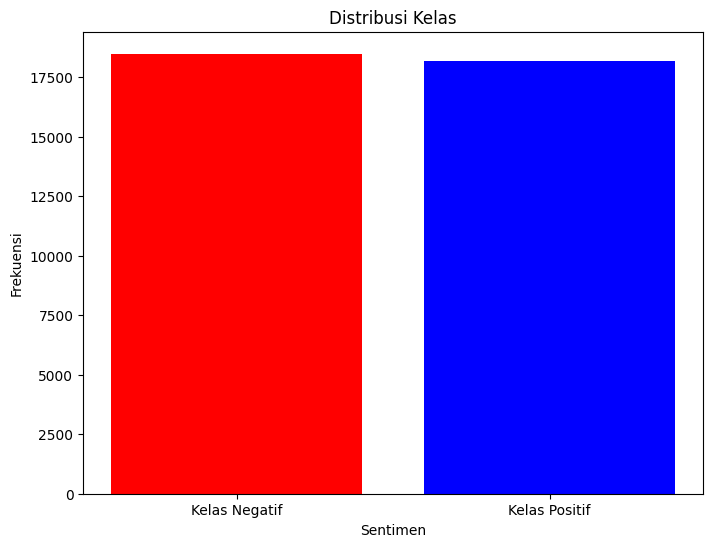

In [14]:
import matplotlib.pyplot as plt

# Data
class_labels = ['Kelas Negatif', 'Kelas Positif']
class_counts = [18487, 18180]

# Mengatur warna per kelas
colors = ['red', 'blue']

plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_counts, color=colors)
plt.title('Distribusi Kelas')
plt.xlabel('Sentimen')
plt.ylabel('Frekuensi')

# Tampilkan plot
plt.show()
